In [1]:
from robot_vlp.config import RAW_DATA_DIR
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

2025-04-27 21:01:09.127 | INFO     | robot_vlp.config:<module>:11 - PROJ_ROOT path is: /Users/tyrelglass/PhD/Repositories/robot-vlp


In [11]:
ekf_df = pd.read_csv(RAW_DATA_DIR / 'experiments/live_data/ekf_run.csv', index_col= [0])
enc_df = pd.read_csv(RAW_DATA_DIR / 'experiments/live_data/encoder_run.csv', index_col= [0])

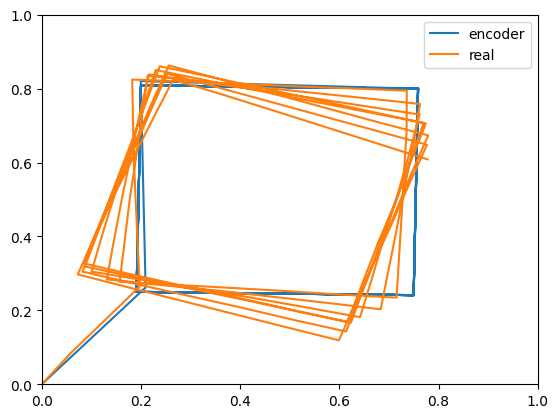

In [38]:
plt.plot(enc_df['encoder_x'], enc_df['encoder_y'], label = 'encoder')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.plot(enc_df['real_x'], enc_df['real_y'], label = 'real')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend()

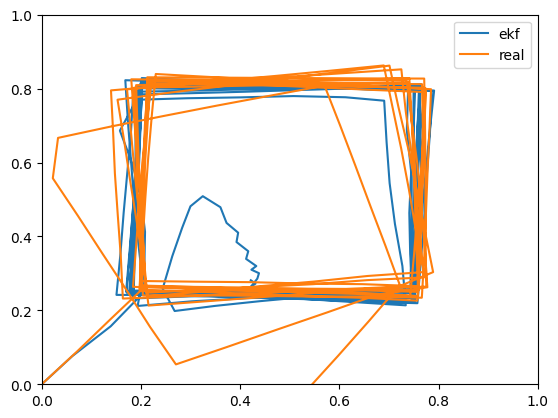

In [26]:
plt.plot(ekf_df['ekf_x'], ekf_df['ekf_y'], label = 'ekf')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.plot(ekf_df['real_x'], ekf_df['real_y'], label = 'real')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend()

In [39]:
def normalize_angle_deg(angle):
    """Normalize an angle in degrees to the range [-180, 180]."""
    return (angle + 180) % 360 - 180

def normalize_angle_rad(angle):
    """Normalize an angle in radians to the range [-π, π]."""
    return (angle + np.pi) % (2 * np.pi) - np.pi

enc_loc_errs = np.sqrt((np.square(enc_df['encoder_x'] - enc_df['real_x']) + np.square(enc_df['encoder_y'] - enc_df['real_y']))[1:].to_list())
enc_ang_errs = normalize_angle_deg((enc_df['encoder_heading'] - enc_df['real_heading']))


ekf_loc_errs = np.sqrt((np.square(ekf_df['ekf_x'] - ekf_df['real_x']) + np.square(ekf_df['ekf_y'] - ekf_df['real_y']))[1:].to_list())
ekf_ang_errs = normalize_angle_deg((ekf_df['ekf_heading'] - ekf_df['real_heading']))

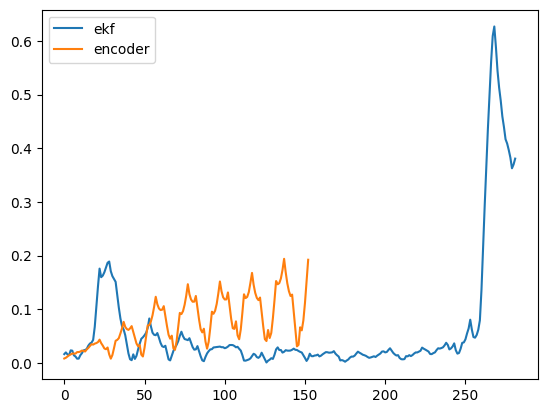

In [40]:
plt.plot(ekf_loc_errs, label = 'ekf')
plt.plot(enc_loc_errs, label = 'encoder')
plt.legend()